# Loading, Testing, and General Image Uploads
This notebook looks at loading in a trained model (saved in the format shown in the training Jupyter notebook) and testing the model on the test set. A confusion matrix are classification report are produced and presented here. The top-k accuracies for all k (from 1 to 101) are computed, printed, and plotted as well.

Next, the notebook looks at loading in images from a given list of image paths, preprocessing, and classifying them. I simply use a random sample of 50 existing Food101 paths from the test set, but any general paths to images can work too. The images are then plotted along with their classifications as their titles. The Food101 images come with true labels, so they are used to demonstrate the model's predictions vs the true labels in the titles.

## Loading Data

In [13]:
import requests
import tarfile
from pathlib import Path

data_path = Path("/kaggle/working/data")
data_path.mkdir(parents=True, exist_ok=True)
print("Using:", data_path)

url = "https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
tgz_path = data_path / "food-101.tar.gz"

print(f"Starting download: {url}")
try:
    with requests.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        downloaded = 0
        chunk_size = 1024 * 1024  # 1MB

        with open(tgz_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    downloaded += len(chunk)
                    if total:
                        pct = downloaded * 100 / total
                        print(f"\rDownloaded {downloaded/1e6:.1f}MB / {total/1e6:.1f}MB ({pct:.1f}%)", end="")
    print("\nDownload finished:", tgz_path)
except Exception as e:
    print("\nDownload failed. On Kaggle, this often means Internet is disabled for the notebook.")
    raise

# Extract
extract_to = Path("/kaggle/working")
print(f"Extracting {tgz_path} to {extract_to} ...")
with tarfile.open(tgz_path, "r:gz") as tar:
    tar.extractall(path=extract_to)
print("Extraction done.")

# Verify expected folders
directory_name = Path("/kaggle/working/food-101")
print("food-101 exists:", directory_name.exists())
print("images exists:", (directory_name / "images").exists())
print("meta exists:", (directory_name / "meta").exists())

Using: /kaggle/working/data
Starting download: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Downloaded 4996.3MB / 4996.3MB (100.0%)
Download finished: /kaggle/working/data/food-101.tar.gz
Extracting /kaggle/working/data/food-101.tar.gz to /kaggle/working ...
Extraction done.
food-101 exists: True
images exists: True
meta exists: True


In [15]:
# Creating main directory paths
image_path = directory_name / "images"
meta_path = directory_name / "meta"

# Getting list of files in the 'food-101/meta' directory
meta_filenames_list = sorted(list(meta_path.glob("*"))) # ignoring the README file
meta_filenames_list

[PosixPath('/kaggle/working/food-101/meta/classes.txt'),
 PosixPath('/kaggle/working/food-101/meta/labels.txt'),
 PosixPath('/kaggle/working/food-101/meta/test.json'),
 PosixPath('/kaggle/working/food-101/meta/test.txt'),
 PosixPath('/kaggle/working/food-101/meta/train.json'),
 PosixPath('/kaggle/working/food-101/meta/train.txt')]

In [16]:
import json
meta_files_data = []

for file_name in meta_filenames_list:
  if str(file_name)[-5:] == ".json":
    data = json.load(open(file_name))
    meta_files_data.append(data)
  elif str(file_name)[-4:] == ".txt":
    with open(str(file_name), 'r') as f:
      data = [line.strip() for line in f.readlines()]
    meta_files_data.append(data)

# Based the order off of order that file names appear in meta_filenames_list
class_names, labels, \
test_data_paths_dict, test_data_paths_lst, \
train_data_paths_dict, train_data_paths_lst \
= meta_files_data

train_path = image_path / "train"
test_path = image_path / "test"

image_paths_list = list(image_path.glob("*/*.jpg"))
image_paths_list[0], len(image_paths_list)

(PosixPath('/kaggle/working/food-101/images/hot_and_sour_soup/3662301.jpg'),
 101000)

In [20]:
# === Test Generator ===
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array
from keras.utils import load_img
import tensorflow as tf

BATCH_SIZE = 32
SEED = 10
test_size = 0.25
input_size = 224
data_dir = "/kaggle/working/food-101/images"

test_datagen = ImageDataGenerator(validation_split = test_size)

test_gen = test_datagen.flow_from_directory(data_dir,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    target_size = (input_size, input_size),
    shuffle = False,
    class_mode = 'categorical',
    subset = 'validation',
    seed = SEED)

Found 25250 images belonging to 101 classes.


## Loading Saved Model

In [17]:
# === Model Architecture ===
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall

def build_model(num_classes: int):
    base = EfficientNetB2(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3),
    )

    for layer in base.layers[:-5]:
        layer.trainable = False

    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        loss=CategoricalCrossentropy(),
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy", Precision(), Recall()],
    )
    return model

In [18]:
# === Loading Weights & History ===
import pickle as pkl
from pathlib import Path

RESULTS_PATH = Path("/kaggle/input/datasets/radioapple/effnetb2-model-5-results/kaggle/working/effnetb2_model_5_results")
MODEL_NO = 5  # change if needed

weights_path = RESULTS_PATH / f"model_{MODEL_NO}"
history_path = RESULTS_PATH / f"history_{MODEL_NO}"
opt_path     = RESULTS_PATH / f"opitimizer_{MODEL_NO}"  # note the misspelling matches your save

with open(weights_path, "rb") as f:
    saved_weights = pkl.load(f)

with open(history_path, "rb") as f:
    saved_history = pkl.load(f)

# rebuild + restore
my_model = build_model(num_classes=len(class_names))
my_model.set_weights(saved_weights)

print("Loaded weights. History keys:", saved_history["history"].keys())

31790344/31790344 [==============================] - 0s 0us/step
Loaded weights. History keys: dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


## Testing

In [21]:
results = my_model.evaluate(test_gen, verbose=1)
print(dict(zip(my_model.metrics_names, results)))

790/790 [==============================] - 1772s 2s/step - loss: 1.0983 - accuracy: 0.7317 - precision: 0.8180 - recall: 0.6850
{'loss': 1.0982820987701416, 'accuracy': 0.7316831946372986, 'precision': 0.8180398941040039, 'recall': 0.6849504709243774}


### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_prob = my_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes  # integers aligned with class_indices because shuffle=False

print("Accuracy (from preds):", accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

790/790 [==============================] - 1793s 2s/step
Accuracy (from preds): 0.7316831683168317
Confusion matrix shape: (101, 101)


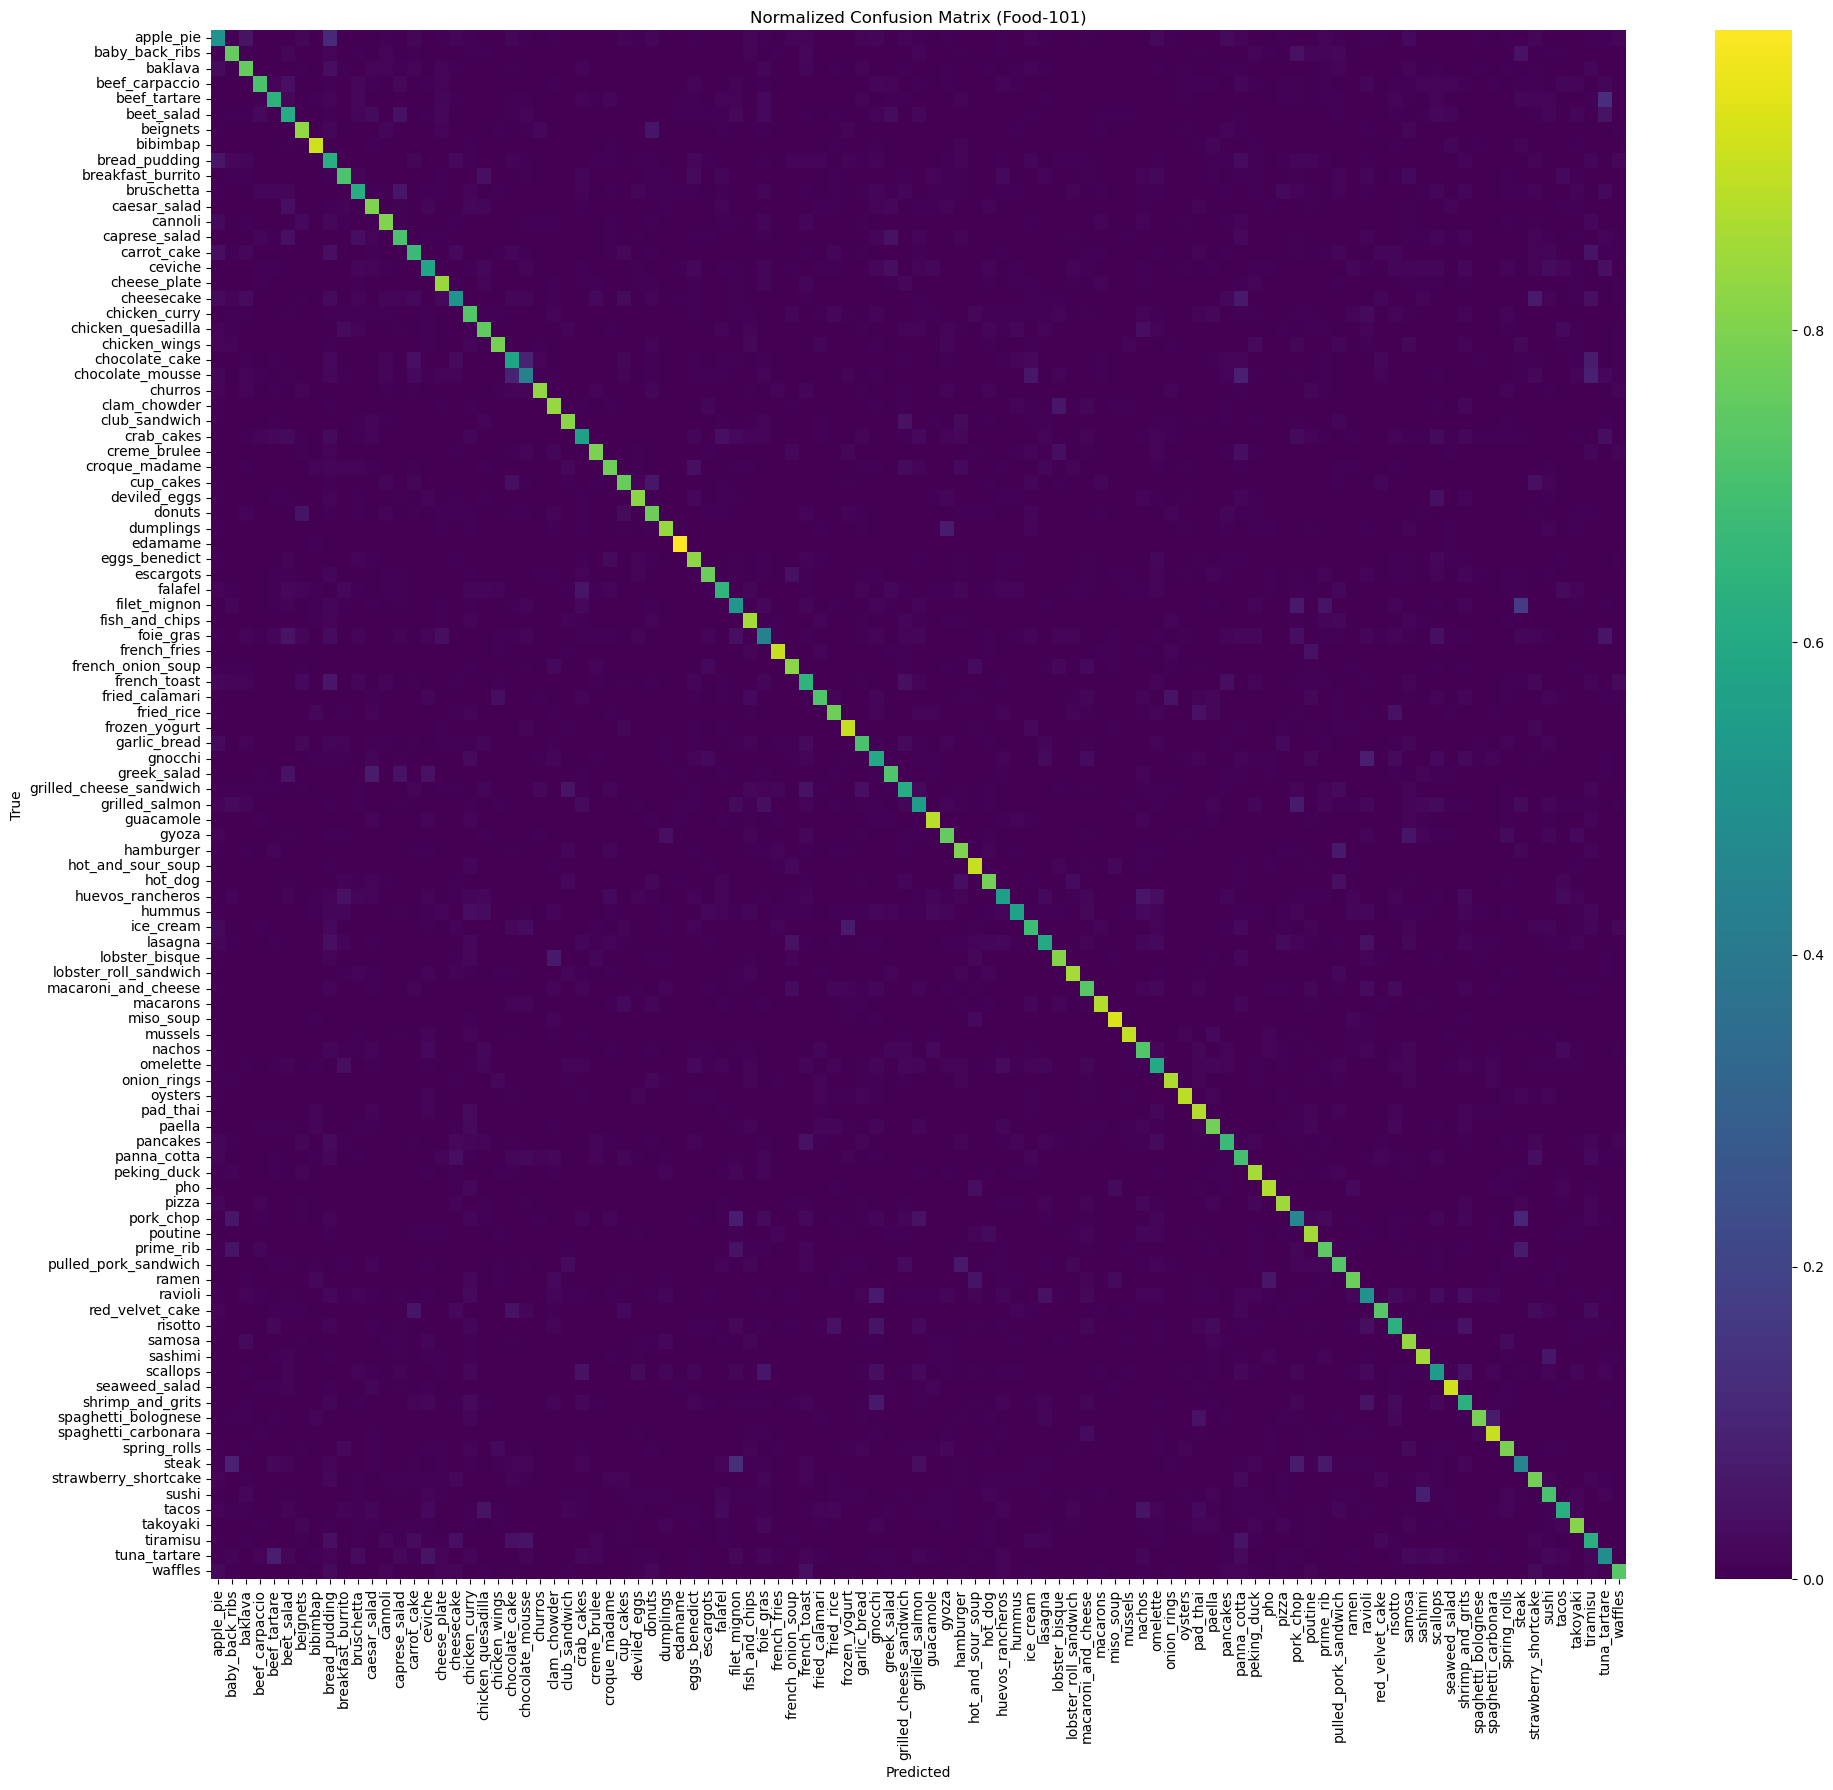

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Normalize for readability
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Get class names in correct order
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
class_labels = [idx_to_class[i] for i in range(len(idx_to_class))]

plt.figure(figsize=(20, 18))
sns.heatmap(
    cm_norm,
    cmap="viridis",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar=True
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Normalized Confusion Matrix (Food-101)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [28]:
cm_norm

array([[0.508, 0.004, 0.048, ..., 0.004, 0.004, 0.012],
       [0.004, 0.756, 0.004, ..., 0.   , 0.   , 0.   ],
       [0.024, 0.   , 0.756, ..., 0.012, 0.   , 0.   ],
       ...,
       [0.004, 0.   , 0.004, ..., 0.628, 0.   , 0.   ],
       [0.004, 0.008, 0.   , ..., 0.012, 0.484, 0.   ],
       [0.02 , 0.004, 0.   , ..., 0.008, 0.   , 0.732]])

### Classification Report

In [24]:
from sklearn.metrics import classification_report

idx_to_class = {v: k for k, v in test_gen.class_indices.items()}
target_names = [idx_to_class[i] for i in range(test_gen.num_classes)]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

                         precision    recall  f1-score   support

              apple_pie     0.5100    0.5080    0.5090       250
         baby_back_ribs     0.6799    0.7560    0.7159       250
                baklava     0.7214    0.7560    0.7383       250
         beef_carpaccio     0.8349    0.7080    0.7662       250
           beef_tartare     0.7227    0.6360    0.6766       250
             beet_salad     0.6000    0.6120    0.6059       250
               beignets     0.7841    0.8280    0.8054       250
               bibimbap     0.8842    0.9160    0.8998       250
          bread_pudding     0.4318    0.6200    0.5090       250
      breakfast_burrito     0.7417    0.7120    0.7265       250
             bruschetta     0.6754    0.6160    0.6444       250
           caesar_salad     0.7117    0.8000    0.7533       250
                cannoli     0.8340    0.8040    0.8187       250
          caprese_salad     0.7166    0.7080    0.7123       250
            carrot_cake 

### Top-k Accuracies

In [74]:
y_prob.shape

(25250, 101)

In [75]:
num_classes = y_prob.shape[1]
max_k = num_classes

predictions_test = []
for p in y_prob:
    top_indices = np.argsort(p)[::-1][:max_k]
    predictions_test.append([(int(idx), float(p[idx])) for idx in top_indices])

true_labels_test = test_gen.classes
accuracies = top_k_accuracies(predictions_test, true_labels_test)

max_key_len = max(len(k) for k in accuracies.keys())
for k, v in accuracies.items():
    pct = v * 100
    print(f"{k:<{max_key_len}} : {pct:6.2f}%")

top_1   :  73.17%
top_2   :  82.75%
top_3   :  87.04%
top_4   :  89.52%
top_5   :  91.18%
top_6   :  92.59%
top_7   :  93.54%
top_8   :  94.28%
top_9   :  94.83%
top_10  :  95.26%
top_11  :  95.65%
top_12  :  95.95%
top_13  :  96.31%
top_14  :  96.59%
top_15  :  96.83%
top_16  :  97.09%
top_17  :  97.26%
top_18  :  97.48%
top_19  :  97.65%
top_20  :  97.81%
top_21  :  97.98%
top_22  :  98.09%
top_23  :  98.21%
top_24  :  98.29%
top_25  :  98.36%
top_26  :  98.42%
top_27  :  98.51%
top_28  :  98.62%
top_29  :  98.67%
top_30  :  98.74%
top_31  :  98.80%
top_32  :  98.85%
top_33  :  98.89%
top_34  :  98.98%
top_35  :  99.02%
top_36  :  99.08%
top_37  :  99.14%
top_38  :  99.19%
top_39  :  99.23%
top_40  :  99.27%
top_41  :  99.29%
top_42  :  99.32%
top_43  :  99.33%
top_44  :  99.35%
top_45  :  99.38%
top_46  :  99.41%
top_47  :  99.44%
top_48  :  99.47%
top_49  :  99.50%
top_50  :  99.54%
top_51  :  99.56%
top_52  :  99.57%
top_53  :  99.58%
top_54  :  99.61%
top_55  :  99.64%
top_56  : 

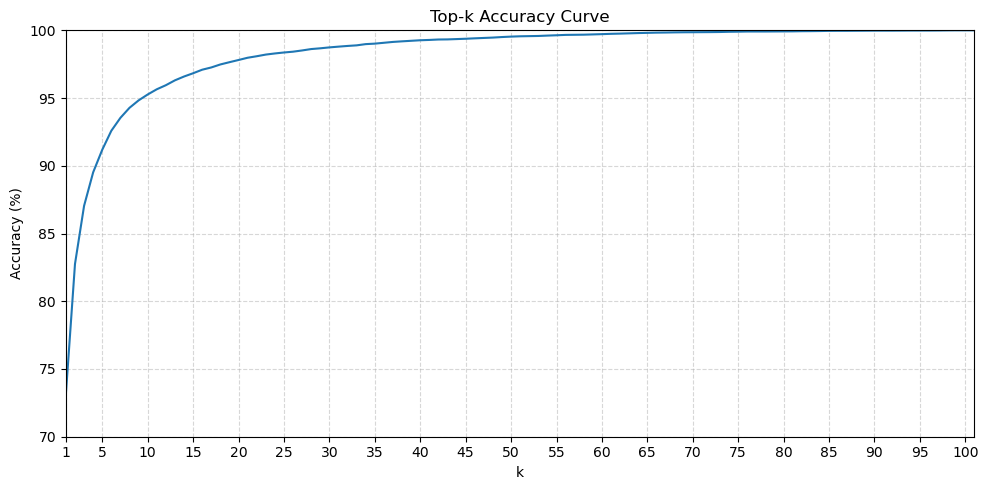

In [91]:
import matplotlib.pyplot as plt

# Extract k values and accuracies as percentages
ks = [int(k.split("_")[1]) for k in accuracies.keys()]
percent_vals = [v * 100 for v in accuracies.values()]

plt.figure(figsize=(10, 5))
plt.plot(ks, percent_vals)

plt.title("Top-k Accuracy Curve")
plt.xlabel("k")
plt.ylabel("Accuracy (%)")
plt.ylim(70, 100)
plt.xticks([1] + list(range(0, max(ks) + 1, 5)))
plt.xlim(1, max(ks))

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Classifying General Images

### Modules

In [68]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import random
    
def load_images(image_paths, target_size=(224, 224)):
    """Load one or more images and return them as a list of PIL images.
    
    === Parameters ===
        - image_paths (list): 
            List of image file paths.
        - target_size (tuple):
            Size to load each image at.
    
    === Returns ===
        list: PIL images loaded at the given size.
    """
    return [load_img(p, target_size=target_size) for p in image_paths]


def preprocess_images(images, target_size=(224, 224)):
    """Load and preprocess one or more images.
    
     === Parameters ===
        - images (PIL.Image.Image or list): 
            A single loaded image or a list of loaded images.
        - target_size (tuple): 
            Expected model input size, default (224, 224).
    
    === Returns ===
        list: preprocessed images, each of shape (1, 224, 224, 3).
    """
    if not isinstance(images, list):
        images = [images]
    out = []
    for img in images:
        arr = img_to_array(img)
        out.append(np.expand_dims(arr, axis=0))
    return out

def view_preprocessed_image(images, i):
    """View the i-th preprocessed image.
    
     === Parameters ===
        - images (list): 
            List of preprocessed images.
        - i (int): 
            Index of the image to view.
    
    === Returns ===
        None
    """
    img = images[i][0].astype("uint8")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def predict_top_k(model, preprocessed_images, top_k=3):
    """Predict top-k classes for one or more preprocessed images.
    
     === Parameters ===
        - model: 
            The trained model used for prediction.
        - preprocessed_images (list): 
            List of preprocessed images, each of shape (1, H, W, 3).
        - top_k (int): 
            Number of top predictions to return per image.
    
     === Returns ===
        list: For each image, a list of (class_index, probability) tuples.
    """
    # Stack list of (1, H, W, 3) arrays into shape (N, H, W, 3)
    batch = np.vstack(preprocessed_images)
    probs = model.predict(batch) # shape (N, num_classes)

    results = []
    for p in probs:
        top_indices = np.argsort(p)[::-1][:top_k] # Get indices of top-k probabilities
        results.append([(int(idx), float(p[idx])) for idx in top_indices]) # Store (class_index, probability)

    return results

def view_predictions(predictions, images, class_names, num_images=10, indices=None, random_select=False, seed=10, true_labels=None):
    """Plot images with their top-1 predicted class as titles.
    
     === Parameters ===
        - predictions (list): 
            Output from predict_top_k, list of top-k predictions for each image.
        - images (list): 
            Preprocessed images corresponding to the predictions.
        - class_names (list):
            List of class names indexed by class number.
        - num_images (int): 
            How many images to display, default 10.
        - indices (list or None): 
            Manually chosen indices of images to plot. Must match num_images if provided.
        - random_select (bool): 
            If True, randomly pick num_images from the available images.
        - seed (int):
            Random seed for reproducibility.
        - true_labels (list or None):
            True class labels for each image, optional.
    
     === Returns ===
        None
    """

    total = len(images)
    random.seed(seed)

    if indices is not None:
        assert len(indices) == num_images, "Number of indices must match num_images."
        chosen = indices
    else:
        if random_select:
            chosen = random.sample(range(total), num_images)
        else:
            chosen = list(range(min(num_images, total)))

    cols = min(num_images, 5)
    rows = (num_images + cols - 1) // cols
    
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, idx in enumerate(chosen):
        img = images[idx][0].astype("uint8")
        top_pred_index = predictions[idx][0][0]
        pred_name = class_names[top_pred_index]

        if true_labels is not None:
            true_idx = true_labels[idx]
            true_name = class_names[true_idx]
            correct = (top_pred_index == true_idx)
            title = f"pred = {pred_name} \n true = {true_name}"
            color = "green" if correct else "red"
        else:
            title = pred_name
            color = "black"

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title, color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def top_k_accuracies(predictions, true_labels):
    """Compute top-k accuracy for all k available in the predictions.
    
     === Parameters ===
        - predictions (list):
            Output of predict_top_k, each element is a list of (class_index, probability).
        - true_labels (list or array):
            True class indices aligned with the predictions.
    
     === Returns ===
        dict: top-k accuracies for k = 1..max_k.
    """
    max_k = len(predictions[0])
    accuracies = {}

    # Convert predictions to matrix of class indices
    pred_indices = np.array([[p[i][0] for i in range(max_k)] for p in predictions])

    true = np.array(true_labels)

    for k in range(1, max_k + 1):
        correct = np.sum([true[i] in pred_indices[i, :k] for i in range(len(true))])
        accuracies[f"top_{k}"] = correct / len(true)

    return accuracies

### Fetching and Preprocessing Images

In [47]:
# Fetch 50 random images from the test set
import random

val_paths = test_gen.filepaths
random_50_paths = random.sample(val_paths, 50)
random_50_paths[:5]

['/kaggle/working/food-101/images/pho/1226579.jpg',
 '/kaggle/working/food-101/images/pork_chop/1036426.jpg',
 '/kaggle/working/food-101/images/frozen_yogurt/1666374.jpg',
 '/kaggle/working/food-101/images/ramen/1892825.jpg',
 '/kaggle/working/food-101/images/spaghetti_bolognese/1765256.jpg']

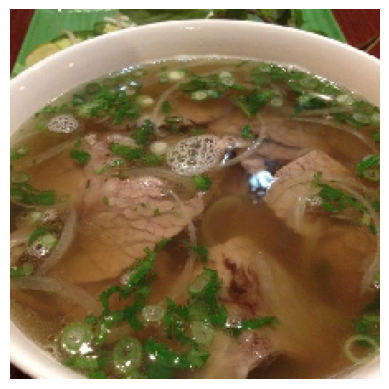

In [52]:
random_50_images = preprocess_images(load_images(random_50_paths))
view_preprocessed_image(random_50_images, 0)

### Predicting Classes

In [56]:
predictions_50_images = predict_top_k(my_model, random_50_images, top_k = 5)

2/2 [==============================] - 3s 1s/step


### Viewing Predictions

# === Getting True Labels ===
all_paths = np.array(test_gen.filepaths)
all_labels = np.array(test_gen.classes)

true_labels_50 = []
for p in random_50_paths:
    idx = np.where(all_paths == p)[0][0] 
    true_labels_50.append(int(all_labels[idx]))

Note that `true_labels` are optional. If not provided, the function will only write the classification in the title.

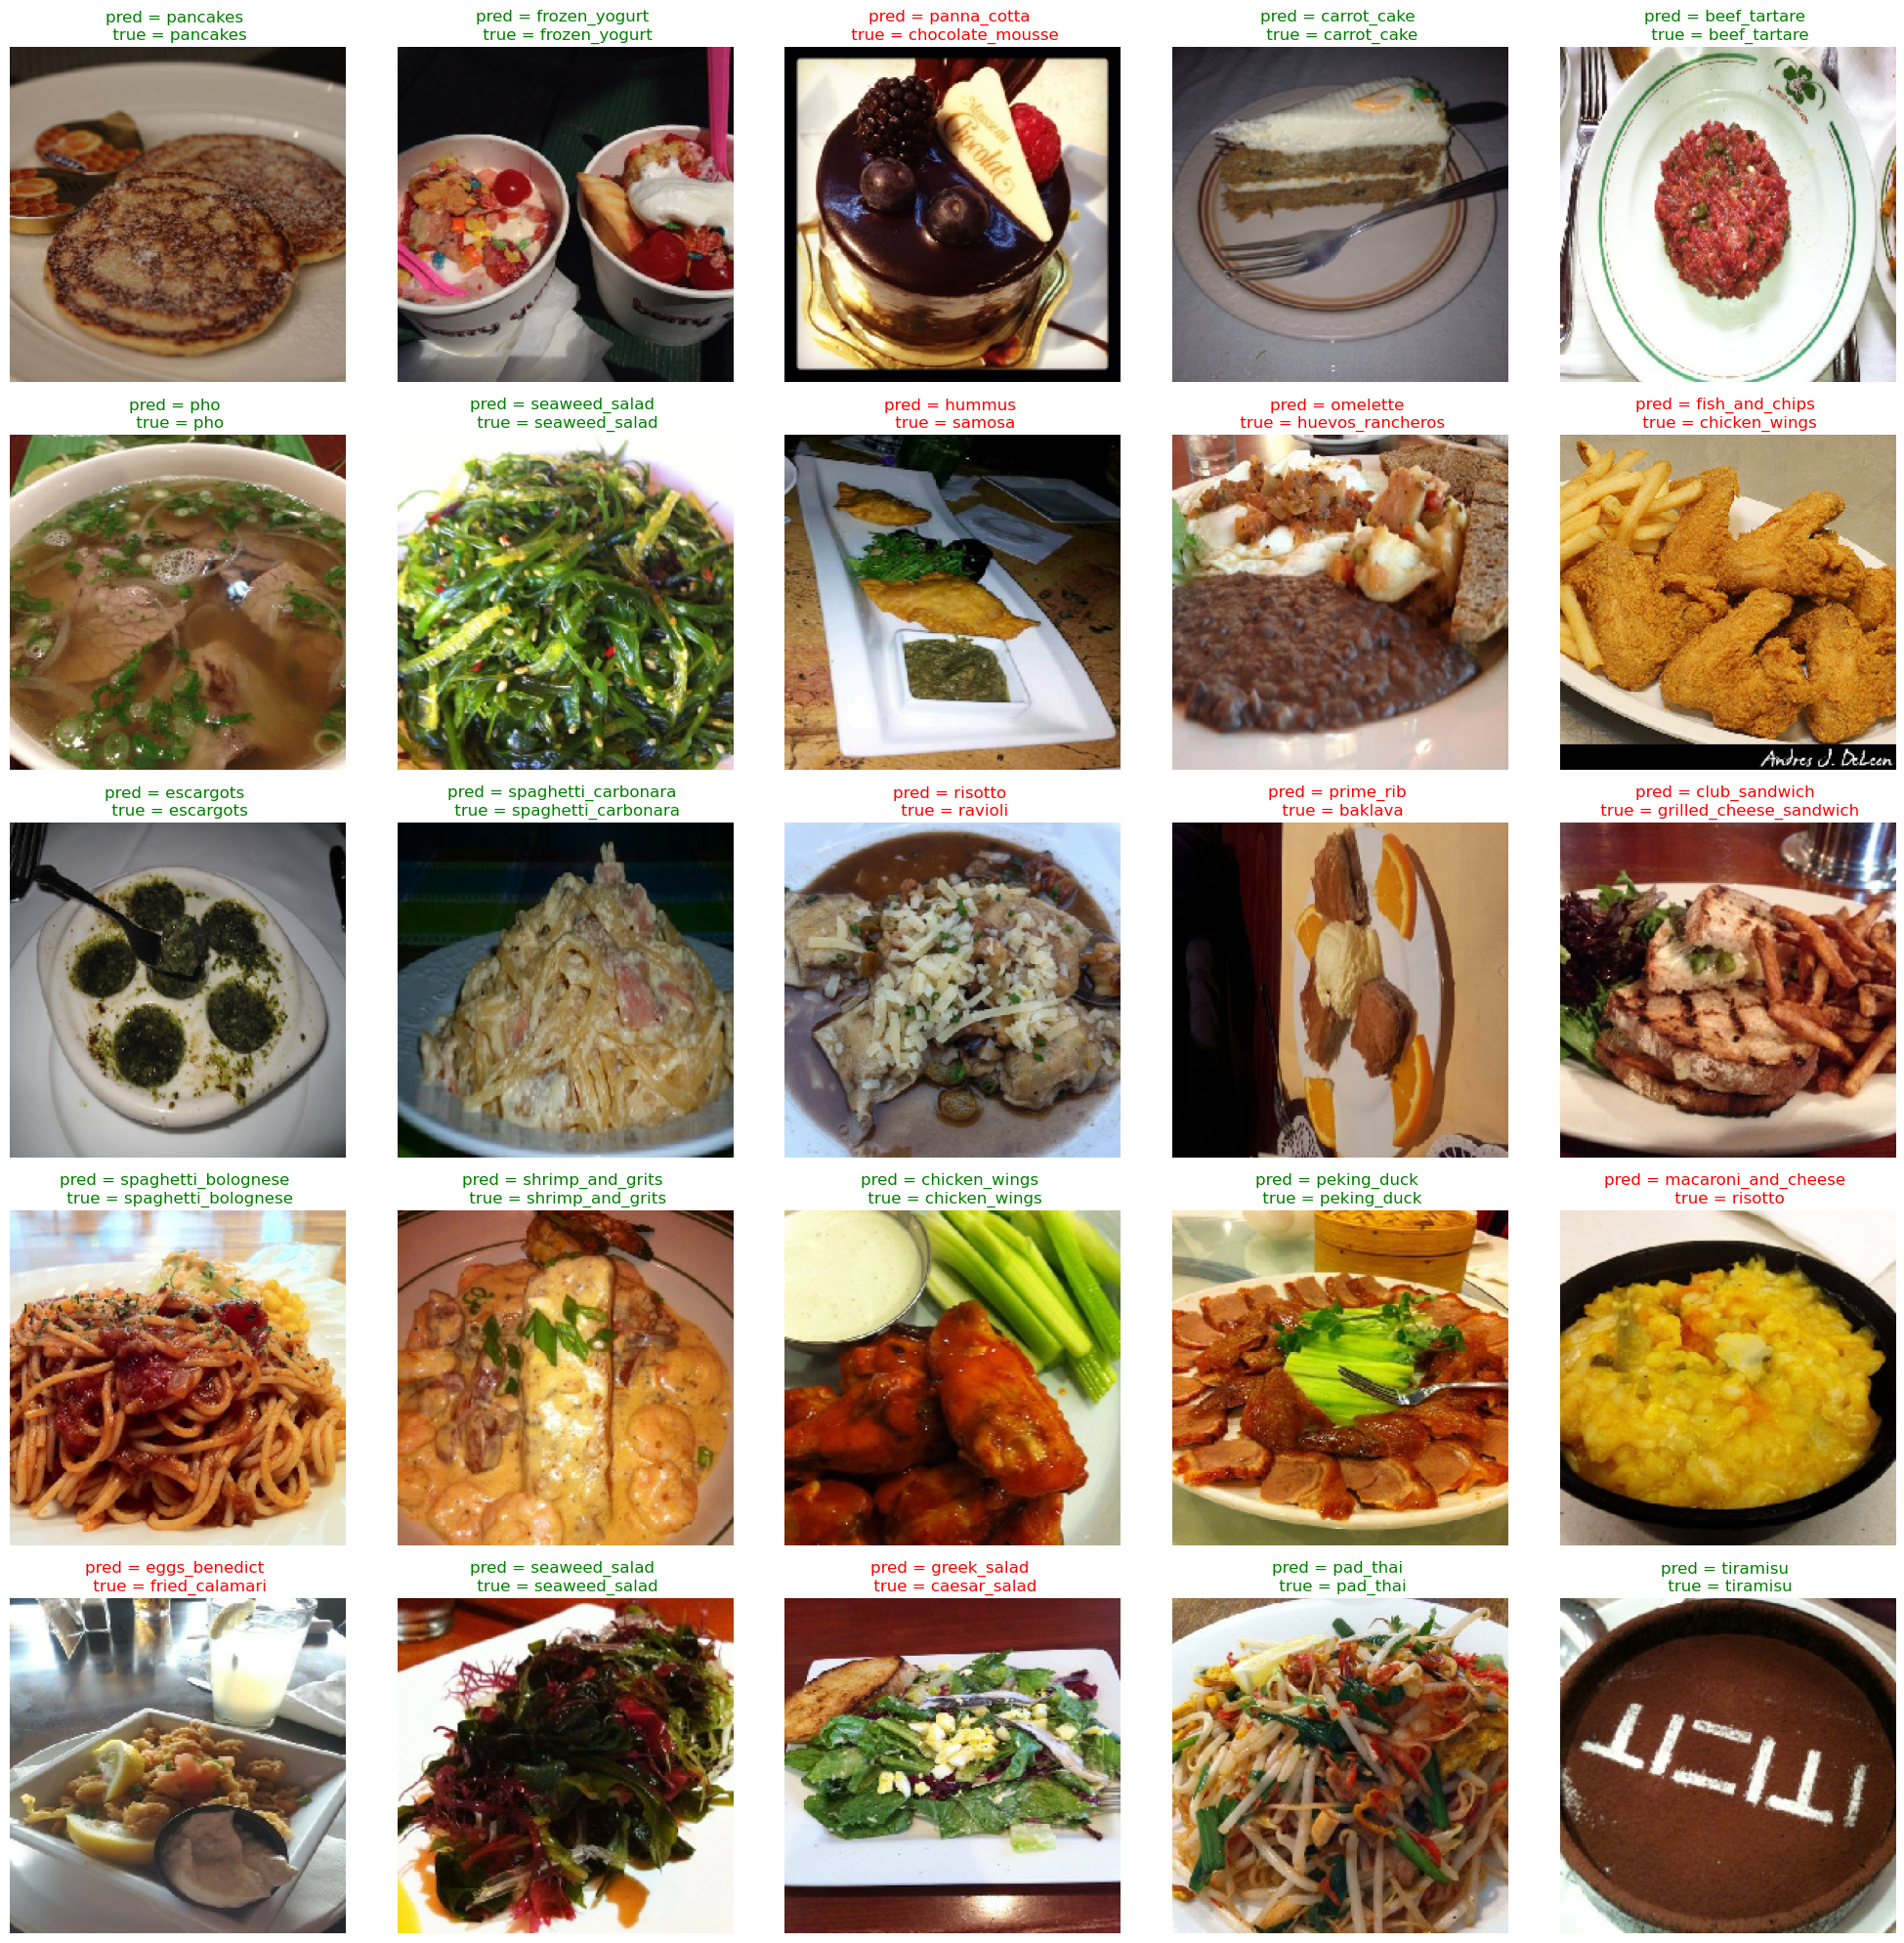

In [70]:
view_predictions(predictions_50_images, random_50_images, class_names, num_images=25, random_select=True, seed=10, true_labels=true_labels_50)

### Top-k

In [61]:
accuracies_50_images = top_k_accuracies(predictions_50_images, true_labels_50)
accuracies_50_images

{'top_1': 0.72, 'top_2': 0.86, 'top_3': 0.94, 'top_4': 0.94, 'top_5': 0.94}